In [1]:
pip install feature-engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 7.4 MB/s 


In [2]:
#Importing required packages.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from feature_engine.outliers import Winsorizer
import feature_engine.transformation as vt

# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from collections import Counter


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

# Ignoring Unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('winequality-red.csv')

In [4]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [5]:
df.shape

(1599, 12)

In [6]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

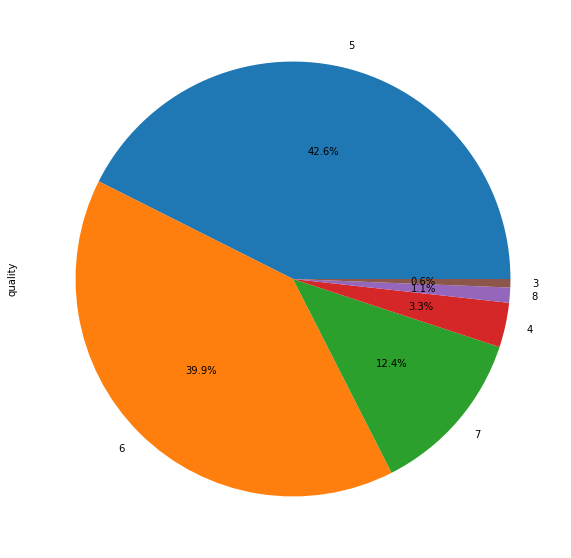

In [7]:
plt.figure(1, figsize=(10,10))
df['quality'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [8]:
df.quality.value_counts(ascending=False)

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [9]:
# Function to create a histogram, and a boxplot and scatter plot.
def diagnostic_plots(df, variable,target):
    # The function takes a dataframe (df) and
    # the variable of interest as arguments.

    # Define figure size.
    plt.figure(figsize=(20, 4))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], bins=30,color = 'r')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'g')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'b')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df)   
    plt.title('Barplot')
    
    
    plt.show()


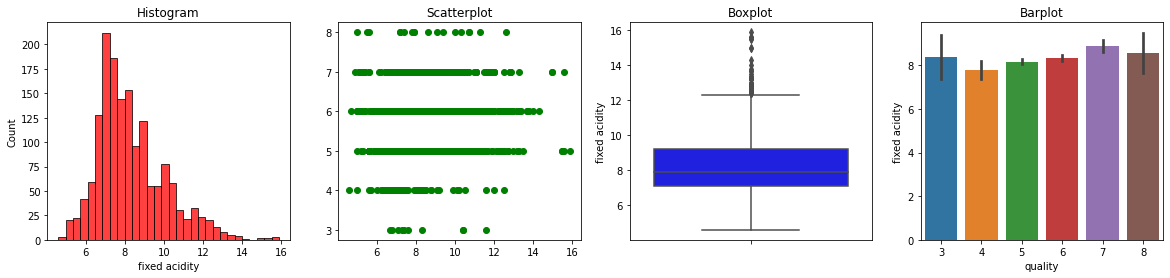

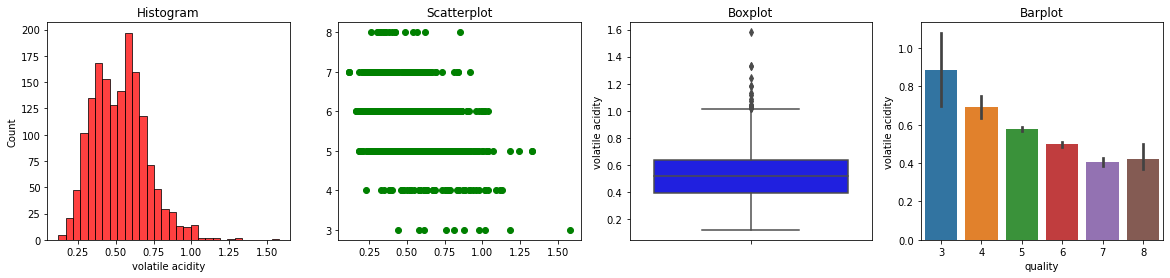

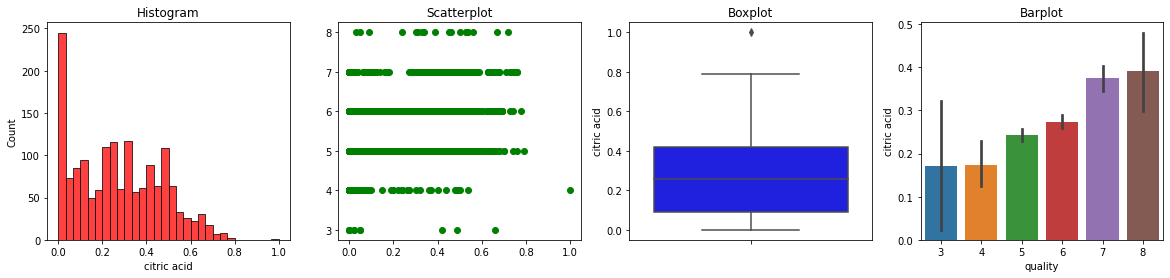

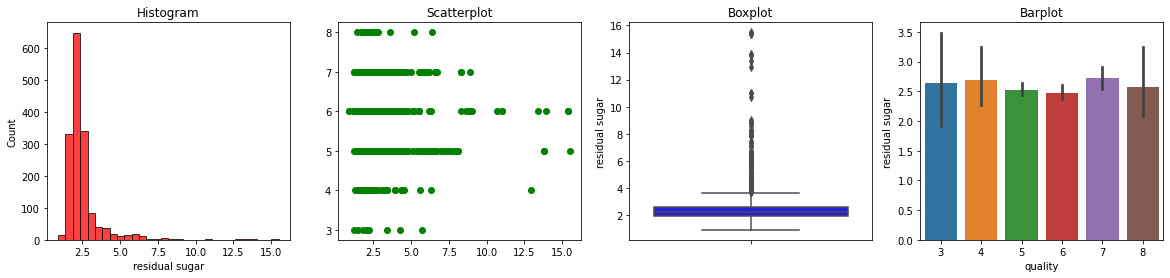

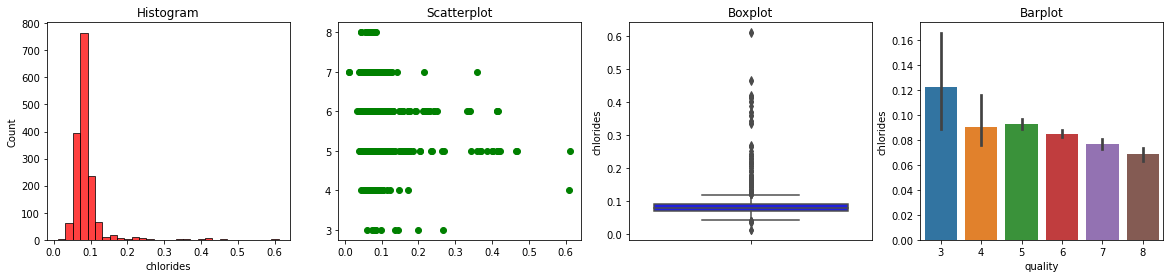

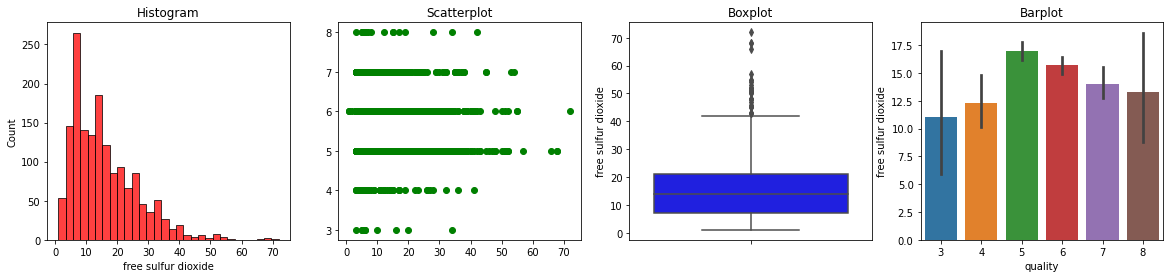

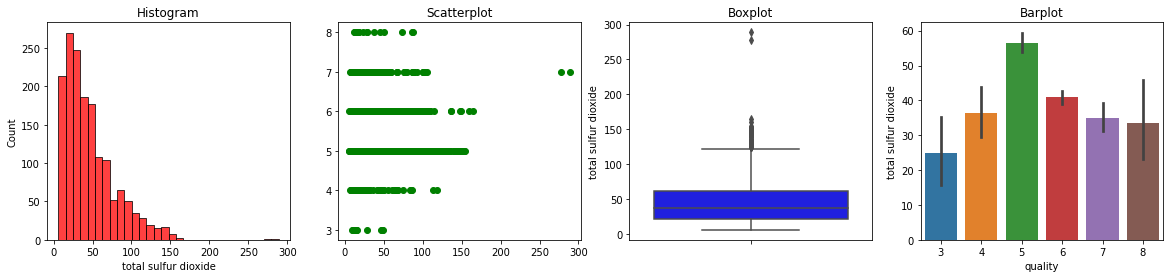

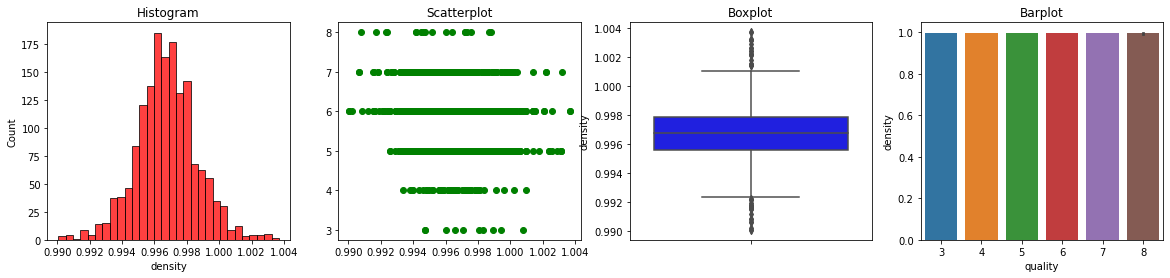

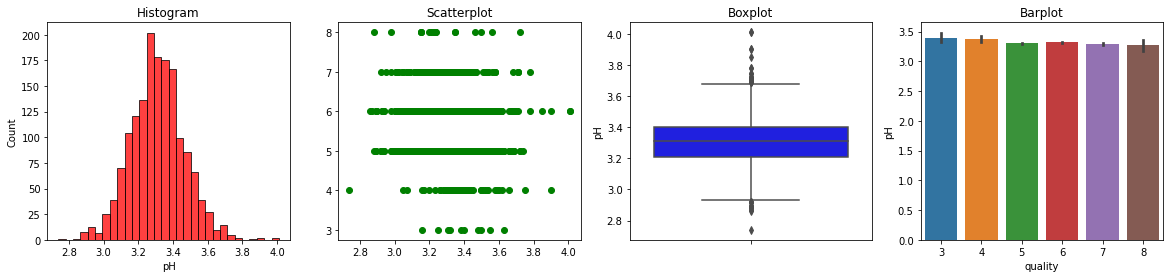

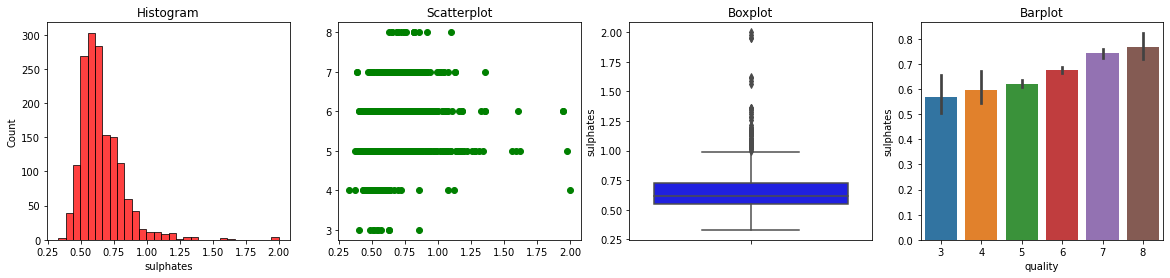

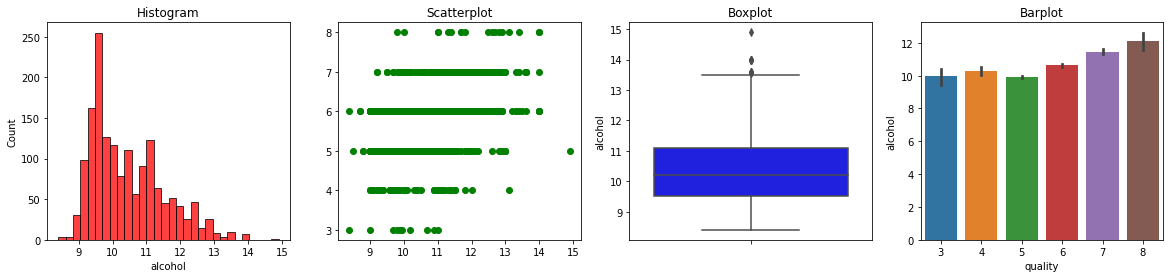

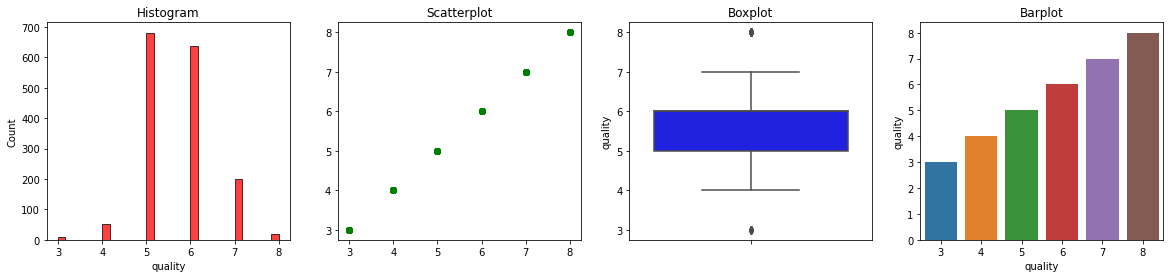

In [10]:
for variable in df:
    diagnostic_plots(df,variable,'quality')

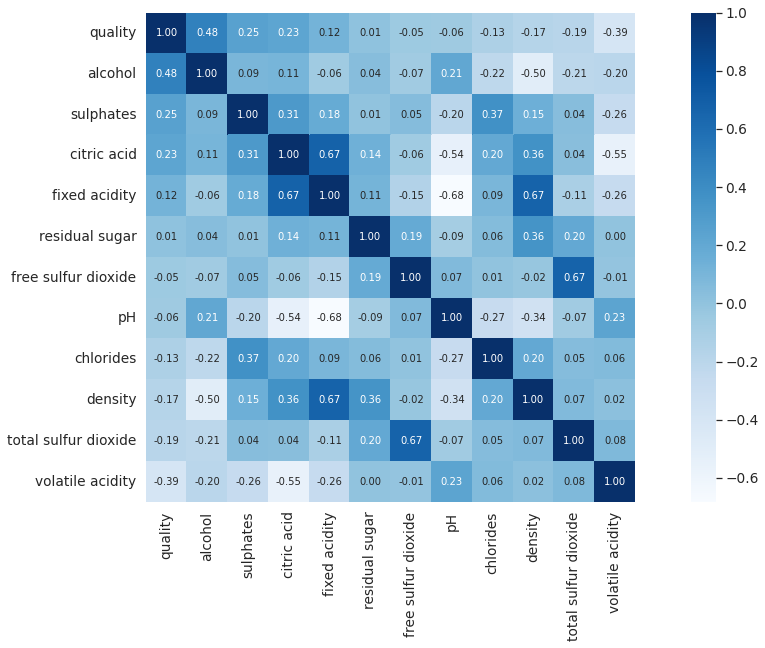

In [11]:
corr = df.corr()
plt.figure(figsize=(20, 9))
k = 12 #number of variables for heatmap
cols = corr.nlargest(k, 'quality')['quality'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,cmap="Blues")
plt.show()

In [12]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [13]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

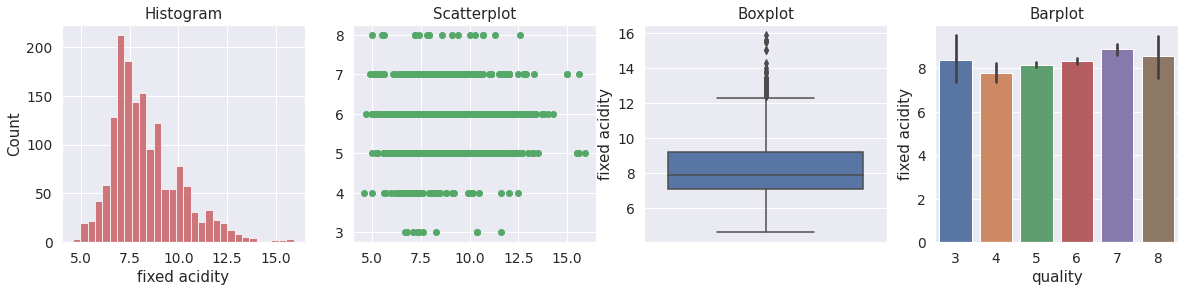

In [14]:
diagnostic_plots(df,'fixed acidity','quality')

In [15]:
df.loc[detect_outliers(df,df.columns[:-1])]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
353,13.5,0.530,0.79,4.8,0.120,23.0,77.0,1.00180,3.18,0.77,13.0,5
364,12.8,0.615,0.66,5.8,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
366,12.8,0.615,0.66,5.8,0.083,7.0,42.0,1.00220,3.07,0.73,10.0,7
374,14.0,0.410,0.63,3.8,0.089,6.0,47.0,1.00140,3.01,0.81,10.8,6
442,15.6,0.685,0.76,3.7,0.100,6.0,43.0,1.00320,2.95,0.68,11.2,7
538,12.9,0.350,0.49,5.8,0.066,5.0,35.0,1.00140,3.20,0.66,12.0,7
554,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
555,15.5,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
557,15.6,0.645,0.49,4.2,0.095,10.0,23.0,1.00315,2.92,0.74,11.1,5
559,13.0,0.470,0.49,4.3,0.085,6.0,47.0,1.00210,3.30,0.68,12.7,6


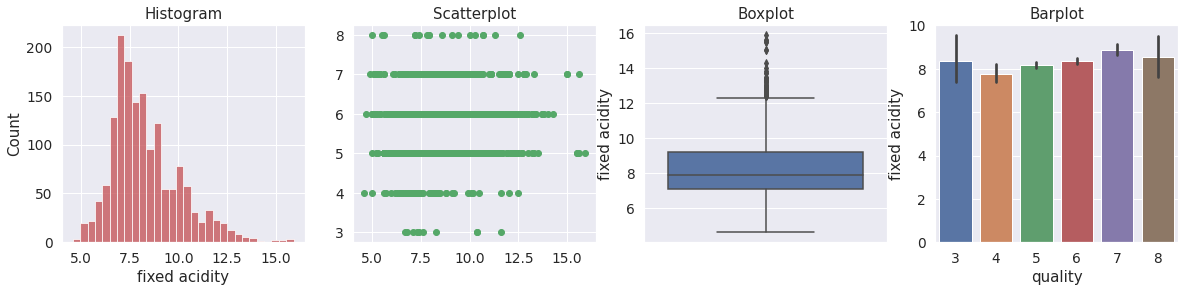

In [16]:
diagnostic_plots(df,'fixed acidity','quality')

In [17]:
#except pH
cols = ['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide',
       'sulphates', 'alcohol']

In [18]:
lt = vt.LogTransformer(variables = cols)

lt.fit(df)

LogTransformer(variables=['fixed acidity', 'volatile acidity', 'residual sugar',
                          'chlorides', 'free sulfur dioxide',
                          'total sulfur dioxide', 'sulphates', 'alcohol'])

In [19]:
df = lt.transform(df)

In [20]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 6.5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

In [21]:
encoder = LabelEncoder()

In [22]:
df['quality'] = encoder.fit_transform(df['quality'])

In [23]:
df['quality'].value_counts()

0    1382
1     217
Name: quality, dtype: int64

In [24]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710,0
1,2.054124,-0.127833,0.00,0.955511,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,2.282382,0
2,2.054124,-0.274437,0.04,0.832909,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,2.282382,0
3,2.415914,-1.272966,0.56,0.641854,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,2.282382,0
4,2.001480,-0.356675,0.00,0.641854,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,2.240710,0


In [25]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1),
                                                    df['quality'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((1119, 11), (480, 11))

In [26]:
# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
dct = DecisionTreeClassifier(random_state = 42)
svc = SVC(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
logreg = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
sgd = SGDClassifier()

In [28]:
# Define the list classifiers
classifiers = [
    ("knn" , knn),
    ("rf" , rf),
    ("logreg" , logreg),
    ("svc", svc),
    ("sgd",sgd),
    ("dct",dct)
]

In [29]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:
    # Fit clf to the training set
    clf.fit(X_train, y_train)
    
    # Predict y_pred
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Evaluate clf's accuracy on the test set
    print('{:s} score : {:.3f}'.format(clf_name, acc))

knn score : 0.890
rf score : 0.921
logreg score : 0.906
svc score : 0.912
sgd score : 0.898
dct score : 0.892


In [30]:
param_grid ={
    'n_estimators' : [50,100,200],
    'max_depth': (1,5,10),
    'min_samples_leaf': (1,5,10)
    }

In [31]:
gridsearch = GridSearchCV(rf, param_grid=param_grid, scoring='accuracy', cv=5,n_jobs=6)

In [32]:
%%capture
gridsearch.fit(X_train,y_train)

In [33]:
gridsearch.best_params_

{'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}

In [34]:
rf = RandomForestClassifier(max_depth= 10, min_samples_leaf = 1, n_estimators = 100)

In [35]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10)

In [36]:
pred = rf.predict(X_test)

In [37]:
print("Accuracy Score:",accuracy_score(pred,y_test))
print("classification Report:\n",classification_report(pred,y_test))

Accuracy Score: 0.925
classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       434
           1       0.60      0.65      0.63        46

    accuracy                           0.93       480
   macro avg       0.78      0.80      0.79       480
weighted avg       0.93      0.93      0.93       480



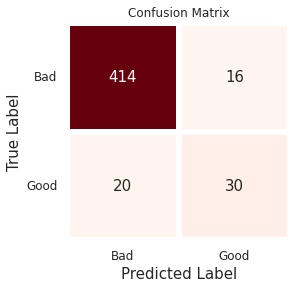

In [38]:
cm = confusion_matrix(y_test, pred)

df1 = pd.DataFrame(columns=["Bad","Good"], index= ["Bad","Good"], data= cm )

f,ax = plt.subplots(figsize=(4,4))

sns.heatmap(df1, annot=True,cmap="Reds", fmt= '.0f',ax=ax,linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

In [39]:
input_data = (7.5,0.5,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.8,10.5)

# changing the input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the data as we are predicting the label for only one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = rf.predict(input_data_reshaped)
print(prediction)

if (prediction[0]==1):
  print('Good Quality Wine')
else:
  print('Bad Quality Wine')

[0]
Bad Quality Wine
